Look at

1. Average month over month growth system-wide
2. Average month over month growth per org
3. Average month over month per month (average growth in April, May, June, etc.) system wide
4. Average month over month per month per org

In [87]:
import pandas as pd
import numpy as np

import sys
sys.path.insert(1, '../../../scripts/')
from s3_support import *
%matplotlib inline

# 1. Average month over month system wide

In [88]:
q = '''select
            count(id) as count,
            sum(amount) as volume,
            date_trunc('month', date) as month,
            count(distinct org) as orgs
        from transactions
            where status='A'
            group by date_trunc('month', date)'''
df_all = redshift_query_read(q)

In [89]:
df_all['month'] = pd.to_datetime(df_all['month'])
df_all.sort_values('month', ascending=True, inplace=True)

In [90]:
df_all['count_growth'] = df_all['count'].diff() / df_all['count'].shift(1)
df_all['volume_growth'] = df_all['volume'].diff() / df_all['volume'].shift(1)
df_all['orgs_growth'] = df_all['orgs'].diff() / df_all['orgs'].shift(1)

In [91]:
df_all.tail()

,count,volume,month,orgs,count_growth,volume_growth,orgs_growth
73,172586,35525001.01,2019-12-01,2272,0.300524,1.337017,0.058221
155,138643,13583707.32,2020-01-01,2088,-0.196673,-0.617630,-0.080986
74,169082,15967177.95,2020-02-01,2133,0.219549,0.175465,0.021552
75,147539,18697187.43,2020-03-01,2174,-0.127412,0.170976,0.019222
156,71909,10047476.35,2020-04-01,1710,-0.512610,-0.462621,-0.213431


In [92]:
print("Mean count growth: {:.2f}".format(df_all['count_growth'].mean()))
print("Mean volume growth: {:.2f}".format(df_all['volume_growth'].replace([np.inf, -np.inf], np.nan).dropna().mean()))

Mean count growth: 0.47
Mean volume growth: 0.10


AxesSubplot(0.125,0.2;0.775x0.68)
AxesSubplot(0.125,0.2;0.775x0.68)


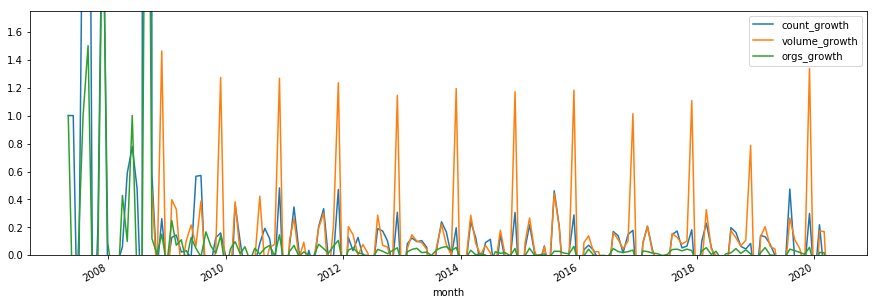

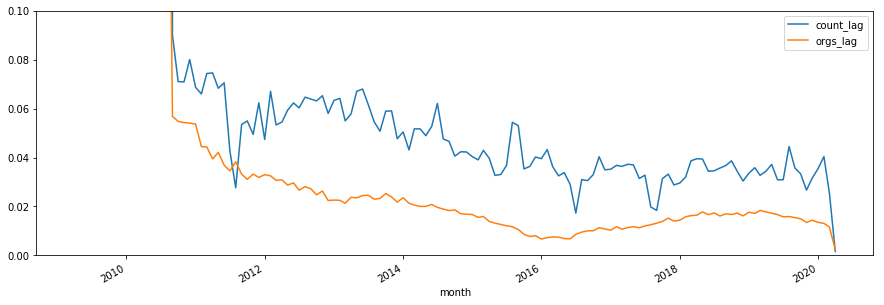

In [93]:
print(df_all[['month', 'count_growth', 'volume_growth', 'orgs_growth']].plot(x='month', y=['count_growth', 'volume_growth', 'orgs_growth'], ylim=(0, 1.75), figsize=(15,5)))

df_all['count_lag'] = df_all['count_growth'].rolling(window=24).mean()
df_all['orgs_lag'] = df_all['orgs_growth'].rolling(window=24).mean()
print(df_all[['month', 'count_lag', 'orgs_lag']].plot(x='month', y=['count_lag', 'orgs_lag'], ylim=(0, 0.1), figsize=(15,5)))

# 2. Average month over month per organization

In [94]:
q = '''select
            org,
            count(distinct form) as forms,
            date_trunc('month', date) as month,
            count(id) as count,
            sum(amount) as volume
        from transactions
            where status='A'
            group by org, date_trunc('month', date)
            order by date_trunc('month', date) desc;'''
df_orgs = redshift_query_read(q)

In [95]:
df_orgs['month'] = pd.to_datetime(df_orgs['month'])
df_orgs.sort_values('month', ascending=False, inplace=True)

In [96]:
org_observations_counts = []
org_data = None
for org in df_orgs['org'].unique().tolist():
    org_df = df_orgs[(df_orgs['org']==org)&(df_orgs['count']>0)].copy()
    
    org_observations_counts.append(len(org_df))
    
    if len(org_df) > 3:
        org_df['count_growth'] = org_df['count'].diff() / org_df['count'].shift(1)
        org_df['volume_growth'] = org_df['volume'].diff() / org_df['volume'].shift(1)

        if org_data is None:
            org_data = org_df
        else:
            org_data = org_data.append(org_df)

len_orgs = len(org_observations_counts)
gt_3 = len([1 for i in org_observations_counts if i > 3])
gt_6 = len([1 for i in org_observations_counts if i > 6])
gt_12 = len([1 for i in org_observations_counts if i > 12])
gt_24 = len([1 for i in org_observations_counts if i > 24])

print("{} organizations".format(len_orgs))
print("{:.2f}% ({}) with more than 3 months observations".format((float(gt_3) / float(len_orgs)) * 100., gt_3))
print("{:.2f}% ({}) with more than 6 months observations".format((float(gt_6) / float(len_orgs)) * 100., gt_6))
print("{:.2f}% ({}) with more than 12 months observations".format((float(gt_12) / float(len_orgs)) * 100., gt_12))
print("{:.2f}% ({}) with more than 24 months observations".format((float(gt_24) / float(len_orgs)) * 100., gt_24))

5144 organizations
76.26% (3923) with more than 3 months observations
65.03% (3345) with more than 6 months observations
52.39% (2695) with more than 12 months observations
36.82% (1894) with more than 24 months observations


In [97]:
org_data.head()

,org,forms,month,count,volume,count_growth,volume_growth
0,441953,1,2020-04-01,61,15726.98,NaN,NaN
2764,441953,2,2020-03-01,42,18516.06,-0.311475,0.177344
4091,441953,1,2020-02-01,5,159.42,-0.880952,-0.991390
7366,441953,1,2020-01-01,5,2080.94,0.000000,12.053193
8765,441953,5,2019-12-01,58,28766.04,10.600000,12.823580


AxesSubplot(0.125,0.2;0.775x0.68)
AxesSubplot(0.125,0.2;0.775x0.68)
AxesSubplot(0.125,0.2;0.775x0.68)


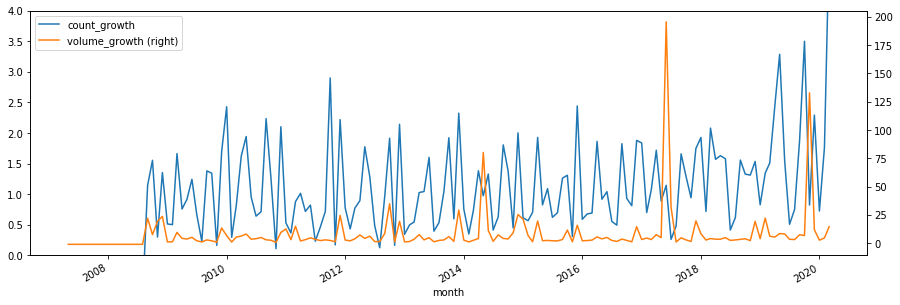

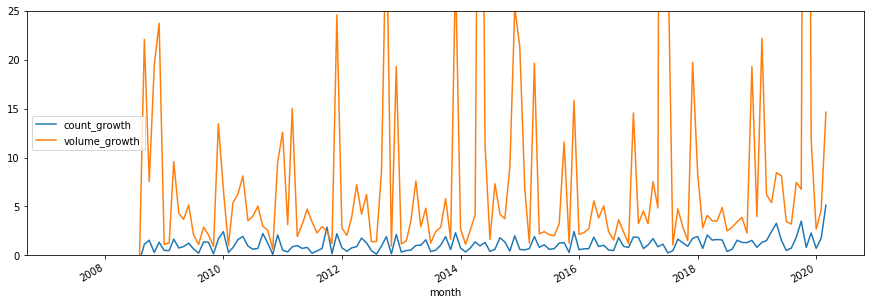

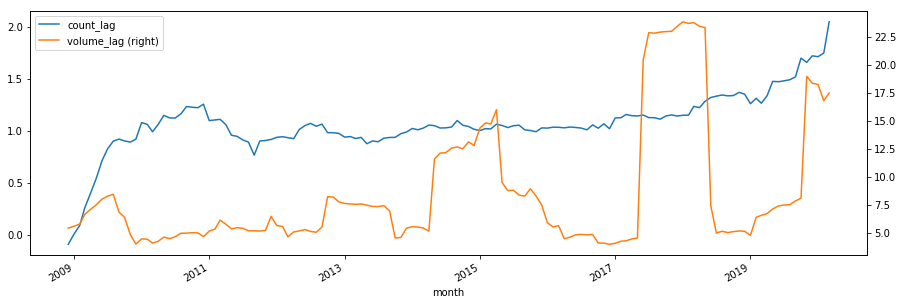

In [98]:
monthly_avg = org_data.replace([np.inf, -np.inf], np.nan).dropna().groupby('month')[['count_growth', 'volume_growth']].mean().reset_index()

print(monthly_avg.plot(x='month', y=['count_growth', 'volume_growth'], secondary_y='volume_growth', ylim=(0,4), figsize=(15,5)))
print(monthly_avg.plot(x='month', y=['count_growth', 'volume_growth'], ylim=(0, 25), figsize=(15,5)))

monthly_avg['count_lag'] = monthly_avg['count_growth'].rolling(window=12).mean()
monthly_avg['volume_lag'] = monthly_avg['volume_growth'].rolling(window=12).mean()

print(monthly_avg.plot(x='month', y=['count_lag', 'volume_lag'], secondary_y='volume_lag', figsize=(15,5)))

In [99]:
org_growth_avg = org_data.replace([np.inf, -np.inf], np.nan).dropna().groupby('org')[['count_growth', 'volume_growth']].mean().reset_index()

In [100]:
org_growth_avg[['count_growth', 'volume_growth']].mean()

count_growth      2.293393
volume_growth    27.674379
dtype: float64

In [101]:
vc = pd.cut(org_growth_avg['volume_growth'], bins=[-12, 0, 0.25, .5, 1, 3, 6, 12, 25, 50, 75, 100]).value_counts(normalize=True, sort=False)

Text(0.5,1,'Average monthly volume growth by organization')

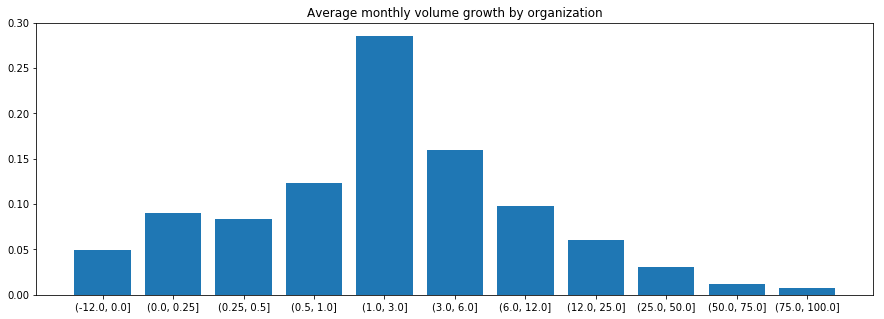

In [102]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.bar([str(k) for k in vc.keys()], vc)
plt.title("Average monthly volume growth by organization")

## Growth consistency

Here we are going to look at the consistency of growth by organizations, month over month. For instance, if an organization experiences a mean growth of 150% month over month, how consistent is that growth rate over the recorded lifetime of the organization. We will do this by examining the __standard deviations__ of the growth rates by organization.

First we will look at a few sample organizations, visualizing their growth rates over time.

In [103]:
sample_orgs = [443211, 668, 443569, 430144, 432158]

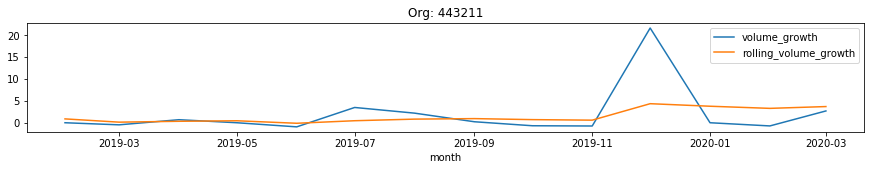

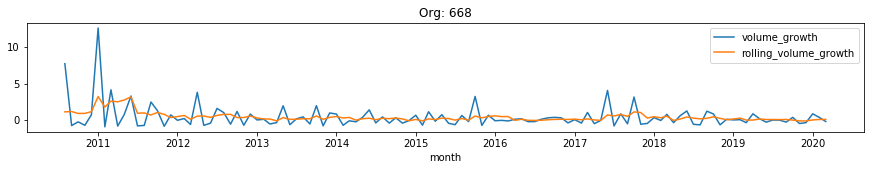

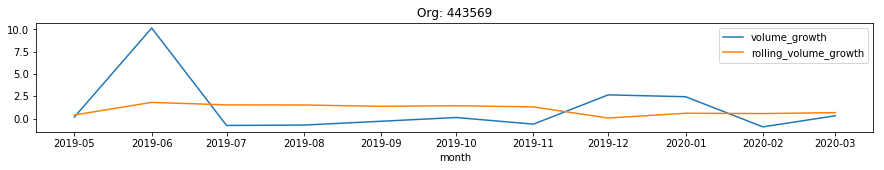

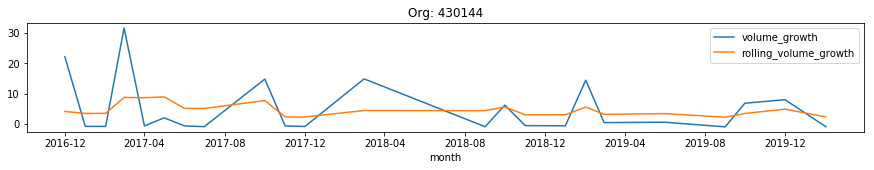

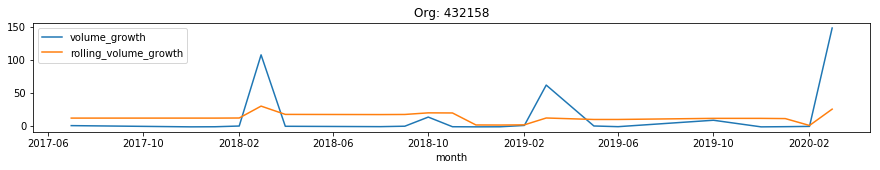

In [104]:
for sample_org in sample_orgs:
    _df = org_data[org_data['org']==sample_org].copy()
    _df['month'] = pd.to_datetime(_df['month']).dt.date
    _df.sort_values('month', inplace=True)
    _df['rolling_volume_growth'] = _df['volume_growth'].rolling(window=6).mean()
    _df = _df[['month', 'volume_growth', 'rolling_volume_growth']].replace([np.inf, -np.inf], np.nan).dropna()
    _df.plot(x='month', title="Org: {}".format(sample_org), figsize=(15,2))

In [105]:
org_growth_std = org_data.replace([np.inf, -np.inf], np.nan).dropna().groupby('org')[['count_growth', 'volume_growth']].std().reset_index()

In [106]:
org_growth_std[['count_growth', 'volume_growth']].mean()

count_growth      6.263241
volume_growth    84.730504
dtype: float64

In [107]:
std_cuts = pd.cut(org_growth_std['volume_growth'], bins=[0.25, .5, 1, 2, 3, 6, 12, 25, 50, 75, 100]).value_counts(normalize=True, sort=False)

Text(0.5,1,'Average standard deviation of monthly volume growth by organization')

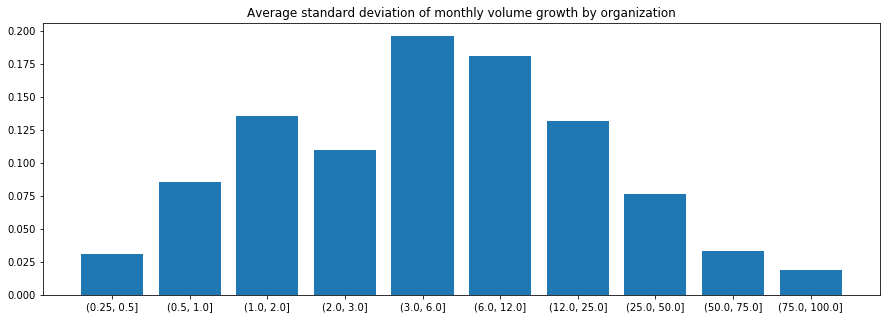

In [108]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.bar([str(k) for k in std_cuts.keys()], std_cuts)
plt.title("Average standard deviation of monthly volume growth by organization")

Here we can see a pretty wide spread. The mean standard deviation is __8566%__ range of growth rates and we can see that the majority of organizations experience a standard deviation between __200%__ and __1200%__. With this kind of range, it's difficult to reasonably claim that organization growth rates are consistent over time.

# 3. Month over month per month system wide

Here we will look at the month over month growth per month, system wide. For example, we will look at the April growth, then compare the April growth year over year to examine the consistency.

In [109]:
q = '''select
            count(id) as count,
            sum(amount) as volume,
            date_trunc('month', date) as month,
            count(distinct org) as orgs
        from transactions
            where status='A'
            group by date_trunc('month', date)'''
df_all = redshift_query_read(q)

In [110]:
df_all['month'] = pd.to_datetime(df_all['month'])
df_all.sort_values('month', ascending=True, inplace=True)
df_all = df_all[df_all['volume']>0.]

In [111]:
df_all['cat_month'] = df_all['month'].dt.month
df_all['count_growth'] = df_all['count'].diff() / df_all['count'].shift()
df_all['volume_growth'] = df_all['volume'].diff() / df_all['volume'].shift()
df_all['orgs_growth'] = df_all['orgs'].diff() / df_all['orgs'].shift()
df_all.tail()

,count,volume,month,orgs,cat_month,count_growth,volume_growth,orgs_growth
73,172586,35525001.01,2019-12-01,2272,12,0.300524,1.337017,0.058221
155,138643,13583707.32,2020-01-01,2088,1,-0.196673,-0.617630,-0.080986
74,169082,15967177.95,2020-02-01,2133,2,0.219549,0.175465,0.021552
75,147539,18697187.43,2020-03-01,2174,3,-0.127412,0.170976,0.019222
156,71909,10047476.35,2020-04-01,1710,4,-0.512610,-0.462621,-0.213431


In [112]:
grpd = df_all.groupby('cat_month')[['count_growth', 'volume_growth', 'orgs_growth']].agg(['std', 'mean'])
grpd

count_growth           volume_growth           orgs_growth          
                   std      mean           std      mean         std      mean
cat_month                                                                     
1             0.107311 -0.250457      0.040923 -0.604653    0.018032 -0.073351
2             0.141149  0.054919      0.139987  0.091278    0.068913  0.039595
3             0.135340  0.166255      0.081900  0.240660    0.021431  0.052825
4             0.172159  0.019682      0.151470 -0.017421    0.074834  0.000923
5             0.065599 -0.032443      0.062805  0.025374    0.024697  0.012329
6             0.094161 -0.025768      0.119892 -0.021009    0.043644  0.006861
7             0.224533 -0.053495      0.085228 -0.093958    0.029421  0.001263
8             0.211762  0.217915      0.156885  0.227089    0.023337  0.034006
9             0.164393  0.132509      0.122412  0.115492    0.040996  0.050487
10            0.196579  0.059572      0.179282  0.028248    0.033853  0.039987
11            0.088834 -0.000929      0.109743  0.017409    0.021094  0.024083
12            0.119359  0.269245      0.168570  1.180667    0.047908  0.076447

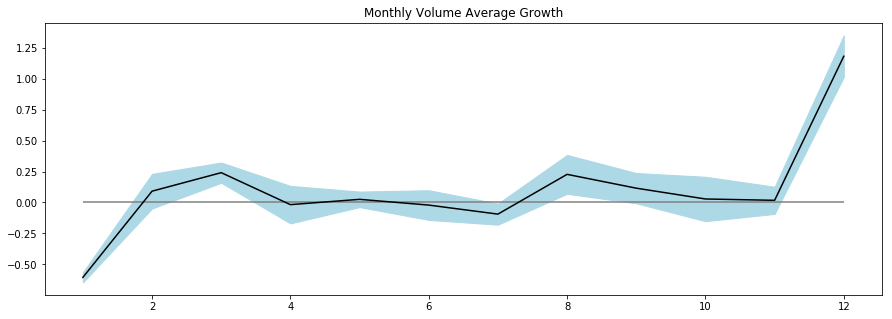

In [113]:
from matplotlib import pyplot as plt
import numpy as np

x = grpd.index
y = grpd['volume_growth']['mean']
error = grpd['volume_growth']['std']

plt.figure(figsize=(15,5))
plt.plot(x, y, 'k-')
plt.hlines(0., 1, 12, color="grey")
plt.fill_between(x, y-error, y+error, color="lightblue")

#plt.plot(x, df_all[df_all['month'].dt.year==2019]['volume_growth'])
#plt.plot(x, df_all[df_all['month'].dt.year==2018]['volume_growth'])
#plt.plot(x, df_all[df_all['month'].dt.year==2017]['volume_growth'])

plt.title("Monthly Volume Average Growth")
plt.show()

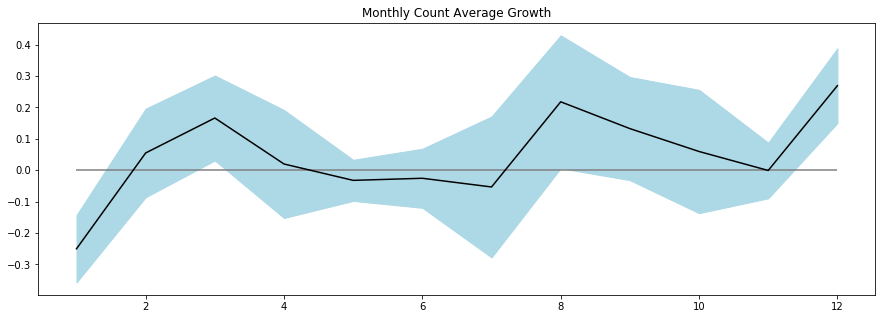

In [114]:
from matplotlib import pyplot as plt
import numpy as np

x = grpd.index
y = grpd['count_growth']['mean']
error = grpd['count_growth']['std']

plt.figure(figsize=(15,5))
plt.plot(x, y, 'k-')
plt.hlines(0., 1, 12, color="grey")
plt.fill_between(x, y-error, y+error, color="lightblue")

#plt.plot(x, df_all[df_all['month'].dt.year==2019]['count_growth'])
#plt.plot(x, df_all[df_all['month'].dt.year==2018]['count_growth'])
#plt.plot(x, df_all[df_all['month'].dt.year==2017]['count_growth'])

plt.title("Monthly Count Average Growth")
plt.show()

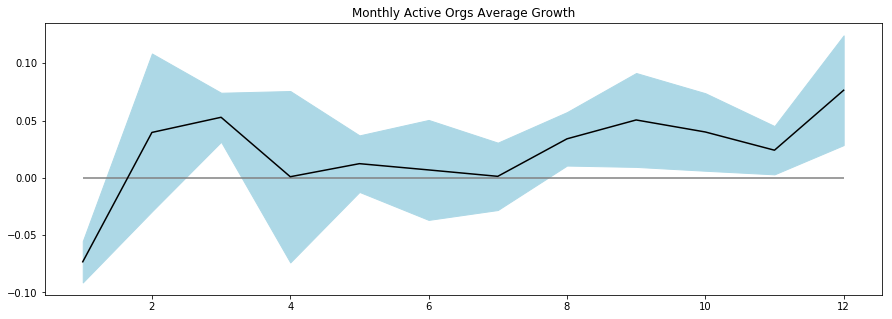

In [115]:
from matplotlib import pyplot as plt
import numpy as np

x = grpd.index
y = grpd['orgs_growth']['mean']
error = grpd['orgs_growth']['std']

plt.figure(figsize=(15,5))
plt.plot(x, y, 'k-')
plt.hlines(0., 1, 12, color="grey")
plt.fill_between(x, y-error, y+error, color="lightblue")

# plt.plot(x, df_all[df_all['month'].dt.year==2019]['orgs_growth'])
# plt.plot(x, df_all[df_all['month'].dt.year==2018]['orgs_growth'])
# plt.plot(x, df_all[df_all['month'].dt.year==2017]['orgs_growth'])

plt.title("Monthly Active Orgs Average Growth")
plt.show()

# 4. Month over month per month per organization

In [116]:
q = '''select
            org,
            count(distinct form) as forms,
            date_trunc('month', date) as month,
            count(id) as count,
            sum(amount) as volume
        from transactions
            where status='A'
            group by org, date_trunc('month', date)'''
df_orgs = redshift_query_read(q)

In [117]:
df_orgs['month'] = pd.to_datetime(df_orgs['month'])
df_orgs['cat_month'] = df_orgs['month'].dt.month
df_orgs.sort_values('month', ascending=True, inplace=True)

In [118]:
org_data = []

for org in df_orgs['org'].unique():
    _org = df_orgs[df_orgs['org']==org].copy()
    _org = _org[_org['volume']>0]
    if len(_org) > 24:
        _org['count_growth'] = _org['count'].diff() / _org['count'].shift()
        _org['volume_growth'] = _org['volume'].diff() / _org['volume'].shift()
        
        this_data = {
            'org': org,
            'forms': _org['forms'].mean(),
            'count_growth': {},
            'volume_growth': {}
        }
        for m in _org['cat_month'].unique():
            this_data['count_growth'][str(m)] = {
                'mean': _org[_org['cat_month']==m]['count_growth'].mean(),
                'std': _org[_org['cat_month']==m]['count_growth'].std()
            }
            this_data['volume_growth'][str(m)] = {
                'mean': _org[_org['cat_month']==m]['volume_growth'].mean(),
                'std': _org[_org['cat_month']==m]['volume_growth'].std()
            }
            
        org_data.append(this_data)

In [119]:
org_data[0]

{'org': 25,
 'forms': 1.7674418604651163,
 'count_growth': {'9': {'mean': 0.0010360010360010348,
   'std': 0.49786189627012795},
  '10': {'mean': 0.5552777777777779, 'std': 0.9619426396492198},
  '11': {'mean': 0.4775555183573261, 'std': 0.4407653202035366},
  '12': {'mean': 0.763388665325285, 'std': 0.538340482430197},
  '1': {'mean': -0.5023918598853154, 'std': 0.14274501292439354},
  '2': {'mean': -0.1899231852218578, 'std': 0.3617823214199457},
  '3': {'mean': -0.006329113924050639, 'std': 0.43223477115905556},
  '4': {'mean': 0.720959595959596, 'std': 2.0466871910983504},
  '5': {'mean': -0.37317471271922614, 'std': 0.26280163666992556},
  '6': {'mean': 0.8748885918003566, 'std': 1.421080089271207},
  '7': {'mean': -0.2090119126615477, 'std': 0.20885011652325405},
  '8': {'mean': -0.24620902198221786, 'std': 0.4954094575982908}},
 'volume_growth': {'9': {'mean': -0.5017923791907765,
   'std': 0.3574225483240404},
  '10': {'mean': 0.4811721597247809, 'std': 0.7221759527374012},
  '

In [120]:
d = []
for entry in [e['count_growth'] for e in org_data]:
    new_entry = {}
    for i in range(1,13):
        if str(i) in entry:
            new_entry["{}_mean".format(i)] = entry[str(i)]['mean']
            new_entry["{}_std".format(i)] = entry[str(i)]['std']
    d.append(new_entry)
count_growth = pd.DataFrame(d)

In [121]:
len(count_growth)

1881

In [122]:
d = []
for entry in [e['volume_growth'] for e in org_data]:
    new_entry = {}
    for i in range(1,13):
        if str(i) in entry:
            new_entry["{}_mean".format(i)] = entry[str(i)]['mean']
            new_entry["{}_std".format(i)] = entry[str(i)]['std']
    d.append(new_entry)
volume_growth = pd.DataFrame(d)

In [123]:
len(volume_growth)

1881

In [124]:
vol_growth_grpd = volume_growth.mean()
[(e, vol_growth_grpd[e]) for e in vol_growth_grpd.index if '_mean' in e]

[('10_mean', 20.971584978885073),
 ('11_mean', 17.33400632290111),
 ('12_mean', 30.930756147878714),
 ('1_mean', 15.332555070830418),
 ('2_mean', 9.591139203688492),
 ('3_mean', 34.944683781196396),
 ('4_mean', 15.007588281114721),
 ('5_mean', 14.825397392150007),
 ('6_mean', 11.70625194601956),
 ('7_mean', 6.920699886630059),
 ('8_mean', 19.150920457811765),
 ('9_mean', 22.904489667103697)]

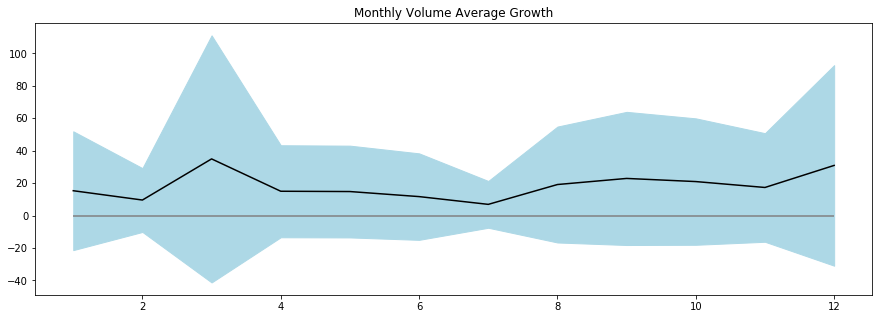

In [125]:
from matplotlib import pyplot as plt
import numpy as np

x = range(1,13)
y = [vol_growth_grpd["{}_mean".format(k)] for k in range(1,13)]
error = [vol_growth_grpd["{}_std".format(k)] for k in range(1,13)]

plt.figure(figsize=(15,5))
plt.plot(x, y, 'k-')
plt.hlines(0., 1, 12, color="grey")
plt.fill_between(x, [a_i - b_i for a_i, b_i in zip(y, error)], [a_i + b_i for a_i, b_i in zip(y, error)], color="lightblue")

plt.title("Monthly Volume Average Growth")
plt.show()

In [126]:
from matplotlib import pyplot as plt
import numpy as np

x = count_growth_grpd.index
y = count_growth_grpd['mean']
error = count_growth_grpd['std']

plt.figure(figsize=(15,5))
plt.plot(x, y, 'k-')
plt.hlines(0., 1, 12, color="grey")
plt.fill_between(x, y-error, y+error, color="lightblue")

plt.title("Monthly Count Average Growth")
plt.show()

NameError: name 'count_growth_grpd' is not defined

## Examining specific sample organizations

In [ ]:
sample_orgs = [443211, 668, 443569, 430144, 432158]

In [ ]:
sample_data = df_orgs[df_orgs['org'].isin(sample_orgs)]

In [ ]:
org_data = []

for org in sample_orgs:
    _org = sample_data[sample_data['org']==org].copy()
    _org = _org[_org['volume']>0]
    if len(_org) > 12:
        _org['count_growth'] = _org['count'].diff() / _org['count'].shift()
        _org['volume_growth'] = _org['volume'].diff() / _org['volume'].shift()
        
        this_data = {
            'org': org,
            'count_growth_mean': {},
            'count_growth_std': {},
            'volume_growth_mean': {},
            'volume_growth_std': {}
        }
        for m in _org['cat_month'].unique():
            this_data['count_growth_mean'][str(m)] = _org[_org['cat_month']==m]['count_growth'].mean()
            this_data['volume_growth_mean'][str(m)] = _org[_org['cat_month']==m]['volume_growth'].mean()
            this_data['count_growth_std'][str(m)] = _org[_org['cat_month']==m]['count_growth'].std()
            this_data['volume_growth_std'][str(m)] = _org[_org['cat_month']==m]['volume_growth'].std()
            
        org_data.append(this_data)

In [ ]:
count_growth_mean = pd.DataFrame([e['count_growth_mean'] for e in org_data])
count_growth_mean = count_growth_mean[[str(i) for i in range(1, 13)]]
volume_growth_mean = pd.DataFrame([e['volume_growth_mean'] for e in org_data])
volume_growth_mean = volume_growth_mean[[str(i) for i in range(1, 13)]]

count_growth_std = pd.DataFrame([e['count_growth_std'] for e in org_data])
count_growth_std = count_growth_std[[str(i) for i in range(1, 13)]]
volume_growth_std = pd.DataFrame([e['volume_growth_std'] for e in org_data])
volume_growth_std = volume_growth_std[[str(i) for i in range(1, 13)]]

In [ ]:
volume_growth_mean

In [ ]:
print(volume_growth_mean.fillna(0).transpose().plot(figsize=(15,3)))
print(volume_growth_mean.fillna(0).transpose().plot(figsize=(15,3), ylim=(0, 50)))

In [ ]:
print(volume_growth_std.fillna(0).transpose().plot(figsize=(15,3)))
print(volume_growth_std.fillna(0).transpose().plot(figsize=(15,3), ylim=(0, 50)))